# Classification of Images (using open source training dataset)

In [8]:
# %pip install matplotlib
# %pip install torch
# %pip install torchvision

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# We are defaulting to CPU, but you may want to compare CPU vs GPU performance
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # Use cpu since this dataset is too small to take advantage of the GPU

In [9]:
# Download training data from open source image datasets
training_data = datasets.FashionMNIST(
    root="../inputs",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets
test_data = datasets.FashionMNIST(
    root="../inputs",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64 # Each element in the dataloader iterable will return a batch of 64 features and labels
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Epoch 1 (3%), Loss: 2.242
Epoch 2 (7%), Loss: 2.143
Epoch 3 (10%), Loss: 1.997
Epoch 4 (13%), Loss: 1.843
Epoch 5 (17%), Loss: 1.708
Epoch 6 (20%), Loss: 1.596
Epoch 7 (23%), Loss: 1.502
Epoch 8 (27%), Loss: 1.424
Epoch 9 (30%), Loss: 1.359
Epoch 10 (33%), Loss: 1.302
Epoch 11 (37%), Loss: 1.253
Epoch 12 (40%), Loss: 1.210
Epoch 13 (43%), Loss: 1.172
Epoch 14 (47%), Loss: 1.138
Epoch 15 (50%), Loss: 1.108
Epoch 16 (53%), Loss: 1.080
Epoch 17 (57%), Loss: 1.055
Epoch 18 (60%), Loss: 1.031
Epoch 19 (63%), Loss: 1.010
Epoch 20 (67%), Loss: 0.990
Epoch 21 (70%), Loss: 0.971
Epoch 22 (73%), Loss: 0.953
Epoch 23 (77%), Loss: 0.937
Epoch 24 (80%), Loss: 0.922
Epoch 25 (83%), Loss: 0.907
Epoch 26 (87%), Loss: 0.894
Epoch 27 (90%), Loss: 0.881
Epoch 28 (93%), Loss: 0.869
Epoch 29 (97%), Loss: 0.857
Epoch 30 (100%), Loss: 0.846


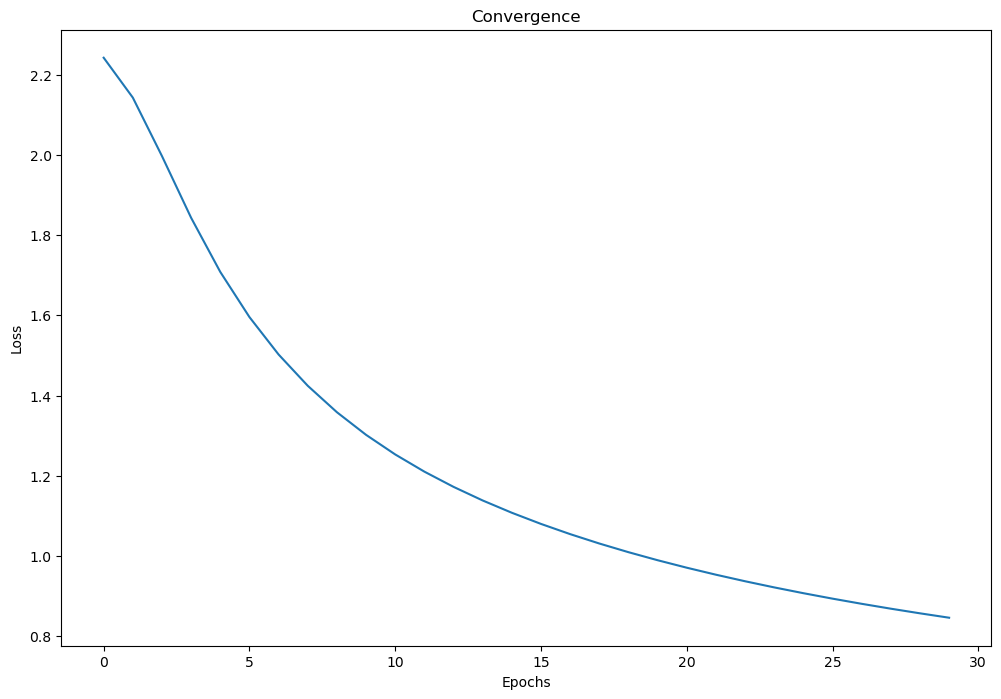

In [10]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device) # The model and tensors used with it, need to be on the same device
criterion = nn.CrossEntropyLoss() # This criterion computes the cross entropy loss between input logits and target.
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # Stochastic Gradient Descent

def train(dataloader, model, criterion, optimizer, num_epochs):
    total_loss = 0
    plot_losses = []
    model.train() # Put the model in "training mode", which turns on dropout and batch normalization
    for epoch in range(1, num_epochs+1):
        iter_loss = 0
        for iter, (X, y_actual) in enumerate(dataloader):
            X, y_actual = X.to(device), y_actual.to(device) # The model and tensors used with it, need to be on the same device
            y_predicted = model(X)
            loss = criterion(y_predicted, y_actual)
            iter_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += iter_loss
        plot_losses.append(total_loss/(iter*epoch))
        percentComplete = epoch/num_epochs*100
        print(f'Epoch {epoch} ({percentComplete:.0f}%), Loss: {total_loss/(iter*epoch):.3f}')
    return plot_losses

# Train the model
plot_losses = train(train_dataloader, model, criterion, optimizer, num_epochs = 30)
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(plot_losses)

In [11]:
def test(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Put the model in "evaluation mode", this turns off dropout and batch normalization.
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) # The model and tensors used with it, need to be on the same device
            y_predicted = model(X)
            test_loss += criterion(y_predicted, y).item()
            correct += (y_predicted.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    accuracy = correct / size * 100
    print(f"Test Accuracy: {accuracy:>0.1f}%")

# Test the model
test(test_dataloader, model, criterion)

Test Accuracy: 80.9%


In [12]:
# Save model
path = "../outputs/image_classification_model.pth"
torch.save(model.state_dict(), path)
print(f"Saved PyTorch Model State to {path}")

Saved PyTorch Model State to ../outputs/image_classification.model


In [13]:
# Load model
model = NeuralNetwork()
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [14]:
# Make predictions using model
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
model.eval() # Put the model in "evaluation mode", this turns off dropout and batch normalization.
x, y = test_data[0][0], test_data[0][1] # x = image, y = predicted category
with torch.no_grad():    
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
